<a href="https://colab.research.google.com/github/erickeagle/AI_for_healthcare/blob/main/Eye_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Eye disease Classification** 

# Loading dataset from kaggle

In [2]:
import json 
dictionary ={"username":"kalashj16","key":"bea86cbea168a032a3b7bc76215e15d8"}
with open("kaggle.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jr2ngb/cataractdataset
! unzip cataractdataset.zip

100% 3.33G/3.34G [01:11<00:00, 48.7MB/s]
100% 3.34G/3.34G [01:11<00:00, 50.2MB/s]
Archive:  cataractdataset.zip
  inflating: README.md               
  inflating: dataset/1_normal/NL_001.png  
  inflating: dataset/1_normal/NL_002.png  
  inflating: dataset/1_normal/NL_003.png  
  inflating: dataset/1_normal/NL_004.png  
  inflating: dataset/1_normal/NL_005.png  
  inflating: dataset/1_normal/NL_006.png  
  inflating: dataset/1_normal/NL_007.png  
  inflating: dataset/1_normal/NL_008.png  
  inflating: dataset/1_normal/NL_009.png  
  inflating: dataset/1_normal/NL_010.png  
  inflating: dataset/1_normal/NL_011.png  
  inflating: dataset/1_normal/NL_012.png  
  inflating: dataset/1_normal/NL_013.png  
  inflating: dataset/1_normal/NL_014.png  
  inflating: dataset/1_normal/NL_015.png  
  inflating: dataset/1_normal/NL_016.png  
  inflating: dataset/1_normal/NL_017.png  
  inflating: dataset/1_normal/NL_018.png  
  inflating: dataset/1_normal/NL_019.png  
  inflating: dataset/1_normal/NL_

# Importing Libraries

In [43]:
import numpy as np
import pandas as pd
import os

import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sb

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Exploring Image Data

In [7]:
#Method to show images
def show_image(img, cmap='gray'):
    fig = plt.figure(figsize=(5,5))
    axes = fig.add_subplot(111)
    axes.imshow(img, cmap=cmap)

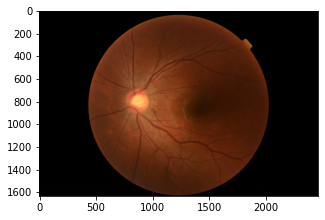

In [8]:
test_img = cv.imread('dataset/1_normal/NL_001.png')
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
show_image(test_img)

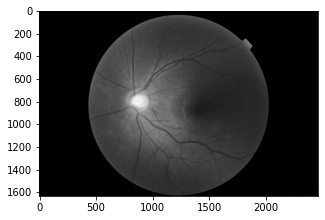

In [9]:
test_img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
show_image(test_img_gray)

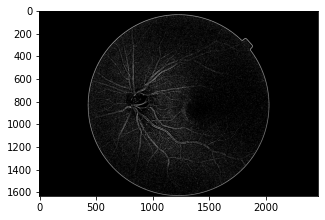

In [10]:
test_img_thresh = cv.adaptiveThreshold(test_img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,3)
show_image(test_img_thresh)

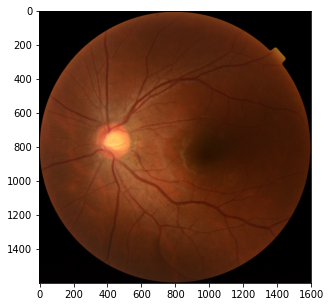

In [11]:
contour = cv.findContours(test_img_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contour = contour[0] if len(contour) == 2 else contour[1]
contour = sorted(contour, key=cv.contourArea, reverse=True)
for i in contour:
    x,y,w,h = cv.boundingRect(i)
    test_img_ROI = test_img[y:y+h, x:x+w]
    break
show_image(test_img_ROI)

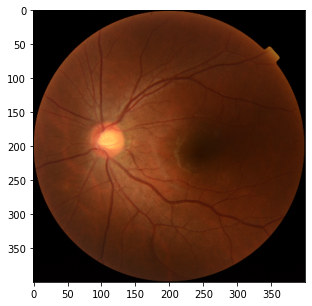

In [14]:
width, height, dimension = test_img_ROI.shape
test_img_ROI_resize = cv.resize(test_img_ROI, (int(width/4), int(height/4)))
show_image(test_img_ROI_resize)

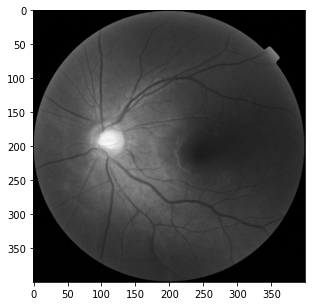

In [15]:
test_img_ROI_resize_gray = cv.cvtColor(test_img_ROI_resize, cv.COLOR_RGB2GRAY)
show_image(test_img_ROI_resize_gray)

In [17]:
def glcm_feature_extraction(matrix_ocurrence, feature_name):
    feature = greycoprops(matrix_ocurrence, feature_name)
    result = np.average(feature)
    return result


distance = 10
teta = 90

contrast_test = []
homogeneity_test = []
energy_test = []
correlation_test = []


glcm = greycomatrix(test_img_ROI_resize_gray, [distance], [teta], levels=256, symmetric=True, normed=True)
contrast_test.append(glcm_feature_extraction(glcm, 'contrast'))
homogeneity_test.append(glcm_feature_extraction(glcm, 'homogeneity'))
energy_test.append(glcm_feature_extraction(glcm, 'energy'))
correlation_test.append(glcm_feature_extraction(glcm, 'correlation'))

print(f'Homogenity : {homogeneity_test[0]}')
print(f'Correlation : {correlation_test[0]}')
print(f'Energy : {energy_test[0]}')
print(f'Contrast : {contrast_test[0]}')

Homogenity : 0.3137214893194543
Correlation : 0.8949450216090933
Energy : 0.09696028302951049
Contrast : 204.1256361569661


# Preprocessing Image

In [26]:
def preprocessing_image(image):
    test_img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    test_img_gray = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
    test_img_thresh = cv.adaptiveThreshold(test_img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,3)
    contour = cv.findContours(test_img_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contour = contour[0] if len(contour) == 2 else contour[1]
    contour = sorted(contour, key=cv.contourArea, reverse=True)
    for i in contour:
        x,y,w,h = cv.boundingRect(i)
        test_img_ROI = test_img[y:y+h, x:x+w]
        break
    test_img_ROI_resize = cv.resize(test_img_ROI, (width, height))
    test_img_ROI_resize_gray = cv.cvtColor(test_img_ROI_resize, cv.COLOR_RGB2GRAY)
    return test_img_ROI_resize_gray

# Feature Extraction

In [27]:
width, height = 400, 400
distance = 10
teta = 90
data_eye = np.zeros((5, 601))
count = 0
index_table = ['contrast', 'homogenity', 'energy', 'correlation', 'Label']


In [31]:
for file in range(1, 301):
    contrast = []
    homogeneity = []
    energy = []
    correlation = []
    label = 0
    image = cv.imread(f'dataset/1_normal/NL_{str(file).zfill(3)}.png')
    img = preprocessing_image(image)
    
    glcm = greycomatrix(img, [distance], [teta], levels=256, symmetric=True, normed=True)
    contrast.append(glcm_feature_extraction(glcm, 'contrast'))
    homogeneity.append(glcm_feature_extraction(glcm, 'homogeneity'))
    energy.append(glcm_feature_extraction(glcm, 'energy'))
    correlation.append(glcm_feature_extraction(glcm, 'correlation'))
    
    data_eye[0, count] = contrast[0]
    data_eye[1, count] = homogeneity[0]
    data_eye[2, count] = energy[0]
    data_eye[3, count] = correlation[0]
    data_eye[4, count] = label
    
    count += 1

In [32]:
for file in range(1, 101):
    contrast = []
    homogeneity = []
    energy = []
    correlation = []
    label = 1
    image = cv.imread(f'dataset/2_cataract/cataract_{str(file).zfill(3)}.png')
    img = preprocessing_image(image)
    
    glcm = greycomatrix(img, [distance], [teta], levels=256, symmetric=True, normed=True)
    contrast.append(glcm_feature_extraction(glcm, 'contrast'))
    homogeneity.append(glcm_feature_extraction(glcm, 'homogeneity'))
    energy.append(glcm_feature_extraction(glcm, 'energy'))
    correlation.append(glcm_feature_extraction(glcm, 'correlation'))
    
    data_eye[0, count] = contrast[0]
    data_eye[1, count] = homogeneity[0]
    data_eye[2, count] = energy[0]
    data_eye[3, count] = correlation[0]
    data_eye[4, count] = label
    
    count += 1

In [33]:
for file in range(1, 102):
    contrast = []
    homogeneity = []
    energy = []
    correlation = []
    label = 2
    image = cv.imread(f'dataset/2_glaucoma/Glaucoma_{str(file).zfill(3)}.png')
    img = preprocessing_image(image)
    
    glcm = greycomatrix(img, [distance], [teta], levels=256, symmetric=True, normed=True)
    contrast.append(glcm_feature_extraction(glcm, 'contrast'))
    homogeneity.append(glcm_feature_extraction(glcm, 'homogeneity'))
    energy.append(glcm_feature_extraction(glcm, 'energy'))
    correlation.append(glcm_feature_extraction(glcm, 'correlation'))
    
    data_eye[0, count] = contrast[0]
    data_eye[1, count] = homogeneity[0]
    data_eye[2, count] = energy[0]
    data_eye[3, count] = correlation[0]
    data_eye[4, count] = label
    
    count += 1

In [34]:
for file in range(1, 101):
    contrast = []
    homogeneity = []
    energy = []
    correlation = []
    label = 3
    image = cv.imread(f'dataset/3_retina_disease/Retina_{str(file).zfill(3)}.png')
    img = preprocessing_image(image)
    
    glcm = greycomatrix(img, [distance], [teta], levels=256, symmetric=True, normed=True)
    contrast.append(glcm_feature_extraction(glcm, 'contrast'))
    homogeneity.append(glcm_feature_extraction(glcm, 'homogeneity'))
    energy.append(glcm_feature_extraction(glcm, 'energy'))
    correlation.append(glcm_feature_extraction(glcm, 'correlation'))
    
    data_eye[0, count] = contrast[0]
    data_eye[1, count] = homogeneity[0]
    data_eye[2, count] = energy[0]
    data_eye[3, count] = correlation[0]
    data_eye[4, count] = label
    
    count += 1

In [35]:
df= pd.DataFrame(np.transpose(data_eye), columns = index_table)

# Normalizing the  Data

In [36]:
df

,contrast,homogenity,energy,correlation,Label
0,204.125636,0.313721,0.096960,0.894945,0.0
1,335.220717,0.277447,0.093683,0.912148,0.0
2,301.578832,0.318182,0.104449,0.887562,0.0
3,224.192882,0.331177,0.103919,0.914002,0.0
4,576.100074,0.307271,0.112997,0.888428,0.0
...,...,...,...,...,...
596,826.924488,0.312105,0.104945,0.858173,3.0
597,616.965215,0.329957,0.111555,0.909242,3.0
598,434.021055,0.336861,0.115360,0.912927,3.0
599,320.025588,0.258287,0.114448,0.951708,3.0


In [37]:
df.describe()

,contrast,homogenity,energy,correlation,Label
count,601.000000,601.000000,601.000000,601.000000,601.000000
mean,487.770585,0.326224,0.112515,0.896751,1.001664
std,184.722058,0.046393,0.011762,0.021688,1.155421
min,96.840728,0.213335,0.089109,0.807291,0.000000
25%,354.302313,0.297898,0.106022,0.884057,0.000000
50%,475.024788,0.313215,0.113144,0.900284,1.000000
75%,591.621722,0.341498,0.119212,0.911626,2.000000
max,1247.978855,0.517782,0.170701,0.951708,3.000000


In [38]:
features = df.drop(['Label'], axis='columns')
features_scaler = MinMaxScaler()
features = features_scaler.fit_transform(features)
features

array([[0.09319899, 0.32973337, 0.09622744, 0.60695136],
       [0.207082  , 0.21058521, 0.05606246, 0.72606934],
       [0.17785711, 0.34438499, 0.18800413, 0.55583088],
       ...,
       [0.2929104 , 0.40573931, 0.32174015, 0.73146799],
       [0.19388191, 0.14765057, 0.3105528 , 1.        ],
       [0.27672098, 0.12923814, 0.30218012, 0.85711199]])

In [39]:
data_normalization = df.copy()
data_normalization[['contrast', 'homogenity', 'energy', 'correlation']] = features
data_normalization

,contrast,homogenity,energy,correlation,Label
0,0.093199,0.329733,0.096227,0.606951,0.0
1,0.207082,0.210585,0.056062,0.726069,0.0
2,0.177857,0.344385,0.188004,0.555831,0.0
3,0.110632,0.387068,0.181508,0.738907,0.0
4,0.416335,0.308546,0.292769,0.561826,0.0
...,...,...,...,...,...
596,0.634228,0.324425,0.194094,0.352330,3.0
597,0.451835,0.383062,0.275095,0.705949,3.0
598,0.292910,0.405739,0.321740,0.731468,3.0
599,0.193882,0.147651,0.310553,1.000000,3.0


In [40]:
data_normalization.describe()

,contrast,homogenity,energy,correlation,Label
count,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.339603,0.370799,0.286871,0.619456,1.001664
std,0.160469,0.152386,0.144158,0.150173,1.155421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223658,0.277759,0.207288,0.531557,0.000000
50%,0.328531,0.328071,0.294576,0.643923,1.000000
75%,0.429819,0.420970,0.368944,0.722458,2.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000


In [41]:
x = data_normalization.drop(['Label'], axis='columns')
y = data_normalization.Label

# Classification using Machine Learning Algo

In [44]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1,10,20,30],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            "criterion":["gini","entropy"],
                      "n_estimators":np.arange(50,100,10),
                      "min_samples_split":np.arange(2,16,4),
                      "min_samples_leaf":np.arange(1,10,3)
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10,50,100]
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3,7,11,13]
        }
    },
    'DecisionTreeClassifier' : {
        'model': DecisionTreeClassifier(random_state=11),
        'params': {
            
            "criterion":["gini","entropy"],
            "max_depth":np.arange(10,21,4),
            "min_samples_split":np.arange(2,21,4),
            "min_samples_leaf":np.arange(1,10,3)
            }
    },
    'DecisionTreeClassifier' : {
        'model': XGBClassifier(random_state=42,n_jobs=-1),
        'params': {
          "min_child_weight":np.arange(2,16,4),
          "gamma":np.arange(1,10,3),
        "max_depth":np.arange(10,21,4),
          },
    }    
}

In [45]:
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(x, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,0.587410,"{'C': 20, 'kernel': 'poly'}"
1,random_forest,0.584077,"{'criterion': 'gini', 'min_samples_leaf': 7, '..."
2,logistic_regression,0.587383,{'C': 5}
3,KNN,0.555826,{'n_neighbors': 13}
4,DecisionTreeClassifier,0.590702,"{'gamma': 4, 'max_depth': 10, 'min_child_weigh..."


In [46]:
df_score['best_score'].max()

0.5907024793388429

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25)

In [48]:
model = svm.SVC(gamma='auto', C=20, kernel='poly')
model.fit(x_train,y_train)

SVC(C=20, gamma='auto', kernel='poly')

In [49]:
model.score(x_test,y_test)

0.609271523178808

Text(69.0, 0.5, 'Truth')

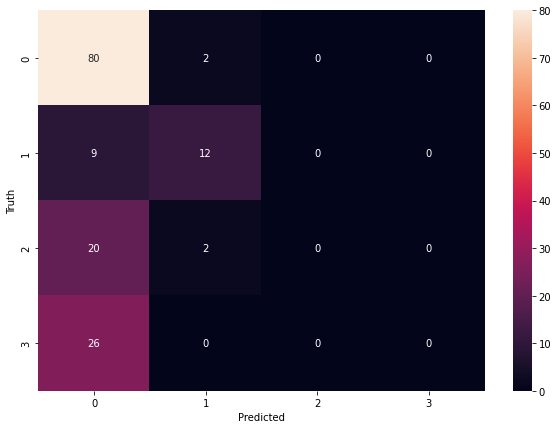

In [50]:
y_predicted = model.predict(x_test)
cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [53]:
model_nn = keras.Sequential([
    keras.layers.Flatten(input_shape=(4,)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(4, activation='sigmoid')
])

model_nn.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_nn.fit(x_train, y_train, epochs=500,batch_size=4,validation_split=0.3)

Epoch 1/500
79/79 [==============================] - 2s 11ms/step - loss: 1.2854 - accuracy: 0.4762 - val_loss: 1.2190 - val_accuracy: 0.4963
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 1.1656 - accuracy: 0.5302 - val_loss: 1.1434 - val_accuracy: 0.5630
Epoch 3/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0921 - accuracy: 0.5460 - val_loss: 1.0887 - val_accuracy: 0.5926
Epoch 4/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0647 - accuracy: 0.5587 - val_loss: 1.0537 - val_accuracy: 0.5704
Epoch 5/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0567 - accuracy: 0.5556 - val_loss: 1.0545 - val_accuracy: 0.5926
Epoch 6/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0573 - accuracy: 0.5556 - val_loss: 1.0583 - val_accuracy: 0.6000
Epoch 7/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0422 - accuracy: 0.5810 - val_loss: 1.0509 - val_accuracy: 0.5704
Epoch 8/500


In [54]:
model_nn.evaluate(x_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 4.4073 - accuracy: 0.4901


[4.407297611236572, 0.4900662302970886]

Text(69.0, 0.5, 'Truth')

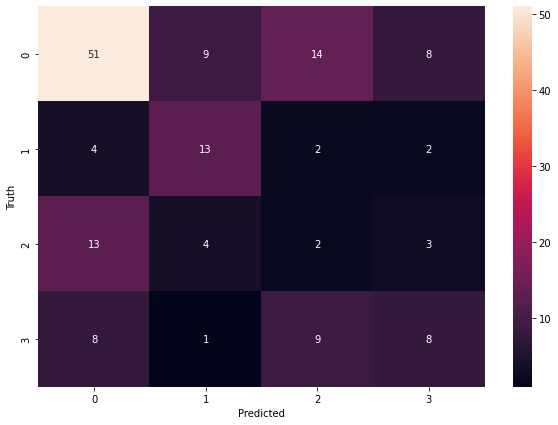

In [55]:
y_predicted = model_nn.predict(x_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')